# <span style="color:DarkGreen"> *Event Total Ice Accumulation (IOP4)* </span>

---
#### This notebook takes observational data from total event ice accumulation and compares to maunally calculated FRAM

## Time Query

In [1]:
#Pick a valid time
year = 2022
month = 2
day = 18
hour = 5
minute = 0

#pick end times
day_end = 18
hour_end = 8
minute_end = 0

# HREF Initialization Time & NYSM Observation Starting Time
year_i = 2022 
month_i = 2 
day_i = 17 
hour_i = 12
minute_i = 0 

# HREF Initialization Hours
starthour = 15 #0,3,6,9,12,15,18    18
endhour = 21 #2,5,8,11,14,17,20     21

## Imports

In [2]:
%matplotlib inline

# core
import os
import sys
import glob
import math
import cfgrib
import requests
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib as mpl

# Collections
from collections import Counter
from functools import reduce

# netCDF4
import netCDF4 as nc
from netCDF4 import Dataset

# datetime
import datetime as dt
from datetime import datetime,timedelta

#cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat 
from cartopy import feature as cfeature

# matplotlib
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.dates import DateFormatter, AutoDateLocator,HourLocator,DayLocator,MonthLocator

# metpy
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot, USCOUNTIES
from metpy.calc import wind_speed, wind_direction, relative_humidity_from_dewpoint, wind_components

# Custom 
import cmap_atmos as cmatmos #custom colormaps
cmap_apcp, norm_apcp, apcp_levs = cmatmos.precip_nws()

In [3]:
# Time Management
beginning_time = datetime(year,month,day,hour,minute)
beginning_time_str = beginning_time.strftime("%Y-%m-%d %H:%M") 
end_time = datetime(year,month,day_end,hour_end,minute_end)
end_time_str = end_time.strftime("%Y-%m-%d %H:%M") 

## File Query

In [4]:
# Time Management
beginning_time = datetime(year,month,day,hour,minute)
beginning_time_str = beginning_time.strftime("%Y-%m-%d %H:%M") 
end_time = datetime(year,month,day_end,hour_end,minute_end)
end_time_str = end_time.strftime("%Y-%m-%d %H:%M") 

# Location (WINTRE-MIX)
latN = 46.5
latS = 44
lonW = -77.0
lonE = -72.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2

# Mesonet Data
fpath_feb17 = '/network/rit/lab/minderlab_rit/field_data/WINTRE_MIX_data/FZRA_data_netcdf/v1.0/WINTRE-MIX_NYSM_icing_detector_20220217_1min.nc'
fpath_feb18 = '/network/rit/lab/minderlab_rit/field_data/WINTRE_MIX_data/FZRA_data_netcdf/v1.0/WINTRE-MIX_NYSM_icing_detector_20220218_1min.nc'
fpath_coords = '/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2019/20190902.nc'
#ds_feb22 = xr.open_dataset(fpath_feb17)
#ds_feb23 = xr.open_dataset(fpath_feb18)
ds_feb = xr.open_mfdataset([fpath_feb17, fpath_feb18])#compat='override'
ds_coords = xr.open_dataset(fpath_coords)
ds_coords['station']=np.array([str(stn.values,'utf-8') for stn in ds_coords['station']])

# Sentinal Data
fpath_ice = '/network/rit/home/je845911/minlab/je845911/data/sentinal/id_0217_0224.nc'
ds_sent = xr.open_dataset(fpath_ice, drop_variables = 'station')

# ASOS Data
df_NY = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_NY_ASOS.csv')
df_VT = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_VT_ASOS.csv')
df_QE = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_QE_ASOS.csv')
df_ON = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_ON_ASOS.csv')
dfs = [df_NY, df_ON, df_QE, df_VT] #Combining the ASOS dataframes from selected stations in Ontario, Quebec, and NY
df_merged = pd.concat(dfs)

# Field observations
obs = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/wintre-mix/IOP4/testing/20220217.txt')

# HREF Coordinate File
core = '/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220217/hiresw_conusarw_2022021712f019.grib2'

# HREF File Grabbing
href_base_dir = '/network/rit/lab/minderlab_rit/je845911/data/href'
yyyymmddhh_str = str(year_i) + str(month_i).zfill(2) + str(day_i).zfill(2) + str(hour_i).zfill(2)
yyyymmdd_str = yyyymmddhh_str[0:8]
yyyy_str = yyyymmddhh_str[0:4]

inc =1 
endhour = endhour +1
fhrs = np.arange(starthour,endhour,inc)
fhrs_adj = np.arange(0,starthour,1)
fhrs_adj_nam = np.arange(0,starthour+1,1)
length = len(fhrs)


arw, fv3, nssl, ncep, nam = [],[],[],[],[]
for fhr in fhrs:
    
    if fhr == starthour:
        arw.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusarw_' + f'{yyyymmddhh_str}f0'+str(fhr-1).zfill(2)+'.grib2')
        nssl.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusnssl_' + f'{yyyymmddhh_str}f0'+str(fhr-1).zfill(2)+'.grib2')
        ncep.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hrrr_ncep_' + f'{yyyymmddhh_str}f0'+str(fhr-1).zfill(2)+'.grib2')
        nam.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/nam_conusnest_' + f'{yyyymmddhh_str}f0'+str(fhr-2).zfill(2)+'.grib2')
        nam.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/nam_conusnest_' + f'{yyyymmddhh_str}f0'+str(fhr-1).zfill(2)+'.grib2')
    
    
    arw.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusarw_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    fv3.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusfv3_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    nssl.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusnssl_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    ncep.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hrrr_ncep_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    nam.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/nam_conusnest_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    
    if fhr == endhour - 1:
        arw.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusarw_' + f'{yyyymmddhh_str}f0'+str(fhr+1).zfill(2)+'.grib2')
        nssl.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusnssl_' + f'{yyyymmddhh_str}f0'+str(fhr+1).zfill(2)+'.grib2')
        ncep.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hrrr_ncep_' + f'{yyyymmddhh_str}f0'+str(fhr+1).zfill(2)+'.grib2')

fv3adj, namadj = [], []
for fhr in fhrs_adj:
    fv3adj.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusfv3_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

for fhr in fhrs_adj_nam:
    namadj.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/nam_conusnest_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

## Sentinal Observations

In [5]:
new_time = []
empty_time = []
sentinal_time = datetime(2021,11,1,0,0)
mock_time = range(0,217440,1)

for i in mock_time:
    adj_time = sentinal_time + timedelta(minutes=i)
    new_time.append(adj_time)
time = np.array(new_time)
ds_sent = ds_sent.assign_coords({"time":time})

for i in mock_time:
    adj_time_var = sentinal_time + timedelta(minutes=i)
    empty_time.append(adj_time_var)
    empty_time.append(adj_time_var)
    empty_time.append(adj_time_var)
    empty_time.append(adj_time_var)

ds_sent_new = ds_sent.copy()
df_sent = ds_sent_new.to_dataframe()
df_sent = df_sent.reset_index(level=1)
df_sent['datetime'] = empty_time
mask_SENT =  (df_sent["datetime"] <= end_time_str) & (df_sent["datetime"] >= beginning_time_str) 
df_sent_mask = df_sent.loc[mask_SENT]
pd.set_option('display.max_rows', None)
cropped_SENT = df_sent_mask[(df_sent_mask["lat"] <= latN) & (df_sent_mask["lat"] >= latS) & (df_sent_mask["lon"] >= lonW) & (df_sent_mask["lon"] <= lonE)]
cropped_SENT = cropped_SENT.drop(columns = 'height_above_mean_sea_level')
cropped_SENT = cropped_SENT.drop(columns = 'heater_status')
cropped_SENT = cropped_SENT.drop(columns = 'ice_status')
SENT_precip = cropped_SENT.groupby(["station",'lat','lon'], as_index=False).agg(ice_sum=("ice", "sum"))
lats_SENT = SENT_precip['lat']
lons_SENT = SENT_precip['lon']
SENT_precip = SENT_precip['ice_sum'] #mm of ice thickness on detector
SENT_precip

0    3.428497
1    0.000000
2    0.000000
3    0.000000
Name: ice_sum, dtype: float64

## NYSM Observations

In [6]:
'''
d
'''
# NYSM Dataframe Managment 
ds_feb_new = ds_feb.copy()
ds_feb_new = ds_feb_new.assign(lat = ds_coords['lat']) # Latitude 
ds_feb_new = ds_feb_new.assign(lon = ds_coords['lon']) # Longitude
df_feb = ds_feb_new.to_dataframe()
df_feb2 = df_feb.reset_index(level=1)
mask_NYSM =  (df_feb2["time"] == end_time_str) 
df_feb_mask = df_feb2.loc[mask_NYSM]
pd.set_option('display.max_rows', None)
cropped_NYSM = df_feb_mask[(df_feb_mask["lat"] <= latN) & (df_feb_mask["lat"] >= latS) & (df_feb_mask["lon"] >= lonW) & (df_feb_mask["lon"] <= lonE)]

NYSM_precip = cropped_NYSM.groupby(["station",'lat','lon'], as_index=False).agg(ice_sum=("T_i_method_2", "mean")) # SUM
lats_NYSM = NYSM_precip['lat']
lons_NYSM = NYSM_precip['lon']
NYSM_precip = NYSM_precip['ice_sum'] # mm of thickeness on detector
NYSM_precip

0    0.5
1    2.0
2    3.0
3    1.0
Name: ice_sum, dtype: float64

## ASOS Observations

In [7]:
cropped_ASOS = df_merged[(df_merged["lat"] <= latN) & (df_merged["lat"] >= latS) & (df_merged["lon"] >= lonW) & (df_merged["lon"] <= lonE)]
cropped_ASOS = cropped_ASOS[(cropped_ASOS["valid"] <= end_time_str) & (cropped_ASOS["valid"] >= beginning_time_str)]
cropped_ASOS.fillna('M', inplace=True)
cropped_ASOS = cropped_ASOS[cropped_ASOS['ice_accretion_1hr'] != 'M']
cropped_ASOS = cropped_ASOS[cropped_ASOS['ice_accretion_1hr'] != 'T']
cropped_ASOS = cropped_ASOS[cropped_ASOS['ice_accretion_1hr'] != '0.00']
cropped_ASOS['ice_accretion_1hr'] = cropped_ASOS.ice_accretion_1hr.astype(float)
ASOS_precip = cropped_ASOS.groupby(["station",'lat','lon','valid'], as_index=False).agg(total_ice=("ice_accretion_1hr", "max"))
ASOS_precip['valid'] = pd.to_datetime(ASOS_precip['valid'])
precip_mask =  (ASOS_precip['station'] == ASOS_precip['station'].shift(1)) & (ASOS_precip['total_ice'] <= ASOS_precip['total_ice'].shift(-1)) & (abs(ASOS_precip['valid'] - ASOS_precip['valid'].shift(1)) < pd.Timedelta('1 hour'))
ASOS_precip.loc[precip_mask, 'to_remove'] = True
ASOS_precip.fillna('False', inplace=True)
ASOS_precip = ASOS_precip.drop(ASOS_precip[ASOS_precip.to_remove == True].index)
ASOS_precip = ASOS_precip.groupby(["station",'lat','lon'], as_index=False).agg(total_ice=("total_ice", "sum"))                                                                   
ASOS_precip ['total_ice'] = ASOS_precip['total_ice']
date = df_merged['valid']
date = pd.to_datetime(date,format="%Y-%m-%d %H:%M")
stid_ASOS = ASOS_precip['station']
lats_ASOS = ASOS_precip['lat']
lons_ASOS = ASOS_precip['lon']
ice_ASOS = ASOS_precip['total_ice']*10
ice_ASOS

0    1.4
1    1.0
2    0.1
Name: total_ice, dtype: float64

## Manual Observations (WINTRE-MIX & LISBON)

In [8]:
lats_OBS = obs['lat'].astype(float)
lons_OBS = obs['lon'].astype(float)-obs['lon'].astype(float)-obs['lon'].astype(float)
OBS_precip = obs['ice'].astype(float)

## FRAM Calculation from "one" HREF ARW File

In [9]:
def features(ax):
    
    # Figure Features
    ax.set_extent ([lonW_c,lonE_c,latS_c,latN_c])
    ax.add_feature (cfeature.LAND.with_scale(res), zorder=1)
    ax.add_feature (cfeature.OCEAN.with_scale(res), zorder=1)
    ax.add_feature (cfeature.LAKES.with_scale(res), zorder=1)
    ax.add_feature(cfeature.COASTLINE.with_scale(res), zorder = 3) 
    ax.add_feature (cfeature.STATES.with_scale(res), zorder = 3)
    ax.add_feature(USCOUNTIES.with_scale(county_scale),zorder =3, linewidth = county_lw)
    
    # Plot Sentinal Observations
    SENT = ax.scatter(lons_SENT, lats_SENT, s = msize, c = SENT_precip, cmap = cmap, norm=norm,transform = ccrs.PlateCarree(),marker='D', zorder = 4, label='SENT', edgecolor=color)
    stationplot_SENT = StationPlot(ax, lons_SENT, lats_SENT, transform=ccrs.PlateCarree(),fontsize=14)
    stationplot_SENT.plot_parameter('N', SENT_precip, color='black', formatter=lambda v: format(v, '.2f'))

    # Plot NYSM Observations
    NYSM = ax.scatter(lons_NYSM, lats_NYSM, s = msize, c = NYSM_precip, cmap = cmap, norm=norm,transform = ccrs.PlateCarree(), zorder = 4, label='NYSM', edgecolor=color)
    stationplot_NYSM = StationPlot(ax, lons_NYSM, lats_NYSM, transform=ccrs.PlateCarree(),fontsize=14)
    stationplot_NYSM.plot_parameter('N', NYSM_precip, color='black', formatter=lambda v: format(v, '.2f'))

    # Plot ASOS Observations
    ASOS = ax.scatter(lons_ASOS, lats_ASOS, s=msize, c = ice_ASOS, cmap = cmap, norm=norm,transform = ccrs.PlateCarree(), zorder = 4, marker='s', label='ASOS', edgecolor=color)
    stationplot_ASOS = StationPlot(ax, lons_ASOS, lats_ASOS, transform=ccrs.PlateCarree(),fontsize=14)
    stationplot_ASOS.plot_parameter('N', ice_ASOS, color='black', formatter=lambda v: format(v, '.2f'))

    # Plot Manual Observations
    OBS = ax.scatter(lons_OBS, lats_OBS, s = msize, c = OBS_precip, cmap = cmap, norm=norm, transform = ccrs.PlateCarree(), zorder = 4, marker = "P", label= 'OBS',edgecolor=color)  
    stationplot_OBS = StationPlot(ax, lons_OBS, lats_OBS, transform=ccrs.PlateCarree(),fontsize=14)
    stationplot_OBS.plot_parameter('N', OBS_precip, color='black', formatter=lambda v: format(v, '.2f'))

frzr_levs_default = [0, 0.01, 0.1, 0.25, 0.50, 1.0, 1.5, 2.0, 3.0, 4.0] #inches
def frzr_cm(levels = frzr_levs_default, return_array = False, omit_trace = True):
    
    frzr_levs = levels
    nws_ice_colors = ['#ffffff', '#f0f34d', '#ffca00', '#ff0000', '#bb0018', '#b665ff', '#9a00d1', '#4f1b75']
    c = np.array([mpl.colors.to_rgb(hxc) for hxc in nws_ice_colors])
    
    if omit_trace:
        c = c[1:]
        frzr_levs = frzr_levs[1:]
    
    if return_array:
        return (c)
    else:
        cmap_frzr = mpl.colors.ListedColormap(c)
        if omit_trace: cmap_frzr.set_under((1,1,1,0)) #set values below min to transparent white
        norm_frzr = mpl.colors.BoundaryNorm(frzr_levs, ncolors = len(c))
        return (cmap_frzr, norm_frzr, frzr_levs)

def LAT(file):
    
    # FZRA for Refernece
    with xr.open_mfdataset(file,engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as arw_cf:
        arw_cfzra = arw_cf['cfrzr']
    LAT = arw_cfzra['latitude']
    return (LAT)

def LON(file):
    
    # FZRA for Refernece
    with xr.open_mfdataset(file,engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as arw_cf:
        arw_cfzra = arw_cf['cfrzr']
    LON = arw_cfzra['longitude']
    return (LON)

def FRAM(file, file2):
    
    # Coords for limited HREF Data so Kevin Does not kill me :)
    hrefN, hrefS, hrefE, hrefW = latN+.7, latS-.9, lonE+360.5 , lonW+359

    # FZRA for Refernece
    with xr.open_mfdataset(file,engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as arw_cf:
        arw_cfzra = arw_cf['cfrzr'].where((arw_cf.latitude >= hrefS) & (arw_cf.latitude <= hrefN) & (arw_cf.longitude >= hrefW) & (arw_cf.longitude <= hrefE))

    # Importing Variables constrined to FZRA points that are = to 1

    # Temperature
    with xr.open_mfdataset(file, engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':167},combine = 'nested') as temp:
        temp_var = temp['t2m'].where((arw_cf['cfrzr'].values == 1)) - 273.15

    # Dewpount
    with xr.open_mfdataset(file, engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':168},combine = 'nested') as dewp:
        dewp_var = dewp['d2m'].where((arw_cf['cfrzr'].values == 1)) - 273.15

    # Pressure
    with xr.open_mfdataset(file, engine = 'cfgrib',filter_by_keys={'typeOfLevel': 'surface', 'stepType': 'instant','paramId':134},combine = 'nested') as pres:
        pres_var = pres['sp'].where((arw_cf['cfrzr'].values == 1))

    # U Winds
    with xr.open_mfdataset(file, engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':165},combine = 'nested') as u:
        u_var = u['u10'].where((arw_cf['cfrzr'].values == 1)) * 1.94384 #m s^-1 to knots

    # V Winds
    with xr.open_mfdataset(file, engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':166},combine = 'nested') as v:
        v_var = v['v10'].where((arw_cf['cfrzr'].values == 1)) * 1.94384 #m s^-1 to knots

    # Total Precipitation over last hour (USING FILE 2) 
    with xr.open_mfdataset(file2, engine = 'cfgrib',filter_by_keys={'stepType': 'accum','typeOfLevel': 'surface','paramId':228228},combine = 'nested') as totp:
        totp_OG_var = totp['tp'].where((arw_cf['cfrzr'].values == 1))

    with xr.open_mfdataset(file, engine = 'cfgrib',filter_by_keys={'stepType': 'accum','typeOfLevel': 'surface','paramId':228228},combine = 'nested') as totp:
        totp_var = totp['tp'].where((arw_cf['cfrzr'].values == 1))
        totp_var = (totp_var - totp_OG_var) * 0.039370 # in/hr 
    
    # Temperature
    temp_var_degc = temp_var.values
    temp_wet = np.float32(temp_var_degc)
    temp_var_degc = np.float32(temp_var_degc) * units.degC

    # Dewpoint
    dewp_var_degc = dewp_var.values 
    dewp_var_degc = np.float32(dewp_var_degc) * units.degC

    # Relative Humidity
    rh = mpcalc.relative_humidity_from_dewpoint(temp_var_degc, dewp_var_degc)*100

    # Wet Bulb Temperature
    def wet_bulb_temperature(T, rh, verbose = False):
        Tw = T * np.arctan(.152 * (rh + 8.3136)**(1/2)) + np.arctan(T + rh) - np.arctan(rh-1.6763) + 0.00391838 * (rh)**(3/2) * np.arctan(0.0231*rh) - 4.686
        return (Tw)
    wet = wet_bulb_temperature(temp_wet, rh)

    # Winds
    u_var_kts = np.float32(u_var) * units.kts
    v_var_kts = np.float32(v_var) * units.kts

    # Wind Speed 
    w_sp = mpcalc.wind_speed(u_var_kts, v_var_kts).magnitude

    # Precip
    pr = totp_var.values

    #ILR (WetBulb, Precipitation, Wind Speed)
    def fram_components(k,pr,v,verbose = False):
        Tw_Com = (-.0071*(k)**3)-(-0.1039*(k)**2)-(0.3904*(k)+(.5545))
        Pr_Com = 0.1395*(pr)**-0.541
        Wd_Com = (0.0014*(v)**2)+(0.0027*(v))+(0.7574)
        return (Tw_Com, Pr_Com, Wd_Com)

    # Wet Bulb Component
    Tw_Com,Pr_Com,Wc_Com = fram_components(wet,pr,w_sp)
    
    A = (0.70*Pr_Com)+(0.29*Tw_Com)+(0.01*Wc_Com)
    B = (0.73*Pr_Com)+(0.01*Tw_Com)+(0.26*Wc_Com)
    C = (0.79*Pr_Com)+(0.20*Tw_Com)+(0.01*Wc_Com)

    A_COND = np.where(wet > .035, A, wet)
    B_COND = np.where((wet <= -0.35) & (Wc_Com > 12), B, A_COND)
    C_COND = np.where((wet <= -0.35) & (Wc_Com <= 12), C, B_COND)
    ILR = C_COND * pr
    return(ILR)

def FRAM_FV3(file):
    
    # Coords for limited HREF Data so Kevin Does not kill me :)
    hrefN, hrefS, hrefE, hrefW = latN+.7, latS-.9, lonE+360.5 , lonW+359

    # FZRA for Refernece
    with xr.open_mfdataset(file,engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as arw_cf:
        arw_cfzra = arw_cf['cfrzr'].where((arw_cf.latitude >= hrefS) & (arw_cf.latitude <= hrefN) & (arw_cf.longitude >= hrefW) & (arw_cf.longitude <= hrefE))

    # Importing Variables constrined to FZRA points that are = to 1

    # Temperature
    with xr.open_mfdataset(file, engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':167},combine = 'nested') as temp:
        temp_var = temp['t2m'].where((arw_cf['cfrzr'].values == 1)) - 273.15

    # Dewpount
    with xr.open_mfdataset(file, engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':168},combine = 'nested') as dewp:
        dewp_var = dewp['d2m'].where((arw_cf['cfrzr'].values == 1)) - 273.15

    # Pressure
    with xr.open_mfdataset(file, engine = 'cfgrib',filter_by_keys={'typeOfLevel': 'surface', 'stepType': 'instant','paramId':134},combine = 'nested') as pres:
        pres_var = pres['sp'].where((arw_cf['cfrzr'].values == 1))

    # U Winds
    with xr.open_mfdataset(file, engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':165},combine = 'nested') as u:
        u_var = u['u10'].where((arw_cf['cfrzr'].values == 1)) * 1.94384 #m s^-1 to knots

    # V Winds
    with xr.open_mfdataset(file, engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':166},combine = 'nested') as v:
        v_var = v['v10'].where((arw_cf['cfrzr'].values == 1)) * 1.94384 #m s^-1 to knots

    # Precipitation
    with xr.open_mfdataset(file, engine = 'cfgrib',filter_by_keys={'stepType': 'accum','typeOfLevel': 'surface','paramId':228228},combine = 'nested') as totp:
        totp_var = totp['tp'].where((arw_cf['cfrzr'].values == 1))
        totp_var = totp_var * 0.039370 # in/hr 
    
    # Temperature
    temp_var_degc = temp_var.values
    temp_wet = np.float32(temp_var_degc)
    temp_var_degc = np.float32(temp_var_degc) * units.degC

    # Dewpoint
    dewp_var_degc = dewp_var.values 
    dewp_var_degc = np.float32(dewp_var_degc) * units.degC

    # Relative Humidity
    rh = mpcalc.relative_humidity_from_dewpoint(temp_var_degc, dewp_var_degc)*100

    # Wet Bulb Temperature
    def wet_bulb_temperature(T, rh, verbose = False):
        Tw = T * np.arctan(.152 * (rh + 8.3136)**(1/2)) + np.arctan(T + rh) - np.arctan(rh-1.6763) + 0.00391838 * (rh)**(3/2) * np.arctan(0.0231*rh) - 4.686
        return (Tw)
    wet = wet_bulb_temperature(temp_wet, rh)

    # Winds
    u_var_kts = np.float32(u_var) * units.kts
    v_var_kts = np.float32(v_var) * units.kts

    # Wind Speed 
    w_sp = mpcalc.wind_speed(u_var_kts, v_var_kts).magnitude

    # Precip
    pr = totp_var.values

    #ILR (WetBulb, Precipitation, Wind Speed)
    def fram_components(k,pr,v,verbose = False):
        Tw_Com = (-.0071*(k)**3)-(-0.1039*(k)**2)-(0.3904*(k)+(.5545))
        Pr_Com = 0.1395*(pr)**-0.541
        Wd_Com = (0.0014*(v)**2)+(0.0027*(v))+(0.7574)
        return (Tw_Com, Pr_Com, Wd_Com)

    # Wet Bulb Component
    Tw_Com,Pr_Com,Wc_Com = fram_components(wet,pr,w_sp)
    
    A = (0.70*Pr_Com)+(0.29*Tw_Com)+(0.01*Wc_Com)
    B = (0.73*Pr_Com)+(0.01*Tw_Com)+(0.26*Wc_Com)
    C = (0.79*Pr_Com)+(0.20*Tw_Com)+(0.01*Wc_Com)

    A_COND = np.where(wet > .035, A, wet)
    B_COND = np.where((wet <= -0.35) & (Wc_Com > 12), B, A_COND)
    C_COND = np.where((wet <= -0.35) & (Wc_Com <= 12), C, B_COND)
    ILR = C_COND * pr
    return(ILR)

def FRAM_NAM(file1,file2,file3):
    # Back1, Back2, Back3
    
    # Coords for limited HREF Data so Kevin Does not kill me :)
    hrefN, hrefS, hrefE, hrefW = latN+.7, latS-.9, lonE+360.5 , lonW+359

    # FZRA for Refernece
    with xr.open_mfdataset(file3,engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as arw_cf:
        arw_cfzra = arw_cf['cfrzr'].where((arw_cf.latitude >= hrefS) & (arw_cf.latitude <= hrefN) & (arw_cf.longitude >= hrefW) & (arw_cf.longitude <= hrefE))

    # Importing Variables constrined to FZRA points that are = to 1

    # Temperature
    with xr.open_mfdataset(file3, engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':167},combine = 'nested') as temp:
        temp_var = temp['t2m'].where((arw_cf['cfrzr'].values == 1)) - 273.15

    # Dewpount
    with xr.open_mfdataset(file3, engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':168},combine = 'nested') as dewp:
        dewp_var = dewp['d2m'].where((arw_cf['cfrzr'].values == 1)) - 273.15

    # Pressure
    with xr.open_mfdataset(file3, engine = 'cfgrib',filter_by_keys={'typeOfLevel': 'surface', 'stepType': 'instant','paramId':134},combine = 'nested') as pres:
        pres_var = pres['sp'].where((arw_cf['cfrzr'].values == 1))

    # U Winds
    with xr.open_mfdataset(file3, engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':165},combine = 'nested') as u:
        u_var = u['u10'].where((arw_cf['cfrzr'].values == 1)) * 1.94384 #m s^-1 to knots

    # V Winds
    with xr.open_mfdataset(file3, engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':166},combine = 'nested') as v:
        v_var = v['v10'].where((arw_cf['cfrzr'].values == 1)) * 1.94384 #m s^-1 to knots
        
    # File 1 Precip
    with xr.open_mfdataset(file1, engine = 'cfgrib',filter_by_keys={'stepType': 'accum','typeOfLevel': 'surface','paramId':228228},combine = 'nested') as totp:
        totp_file1 = totp['tp'].where((arw_cf['cfrzr'].values == 1)) *0.039370 # in/hr
   
    # File 2 Precip
    with xr.open_mfdataset(file2, engine = 'cfgrib',filter_by_keys={'stepType': 'accum','typeOfLevel': 'surface','paramId':228228},combine = 'nested') as totp:
        totp_file2 = totp['tp'].where((arw_cf['cfrzr'].values == 1)) *0.039370 # in/hr
    
    # File 3 Precip 
    with xr.open_mfdataset(file3, engine = 'cfgrib',filter_by_keys={'stepType': 'accum','typeOfLevel': 'surface','paramId':228228},combine = 'nested') as totp:
        totp_file3 = totp['tp'].where((arw_cf['cfrzr'].values == 1)) *0.039370 # in/hr
        
    for i in fhrs:
        i = i - 2
        
        if (i == 0 or 3 or 6 or 9 or 12 or 15 or 18 or 21 or 24 or 27 or 30):
            totp_var = totp_file1
        
        elif (i == 1 or 4 or 7 or 10 or 13 or 16 or 19 or 22 or 25 or 28 or 31):
            totp_var = totp_file1 + totp_file2

        elif (i == 2 or 5 or 8 or 11 or 14 or 17 or 20 or 23 or 26 or 29 or 32):
            totp_var = totp_file1 + totp_file2 + totp_file3
    
    # Temperature
    temp_var_degc = temp_var.values
    temp_wet = np.float32(temp_var_degc)
    temp_var_degc = np.float32(temp_var_degc) * units.degC

    # Dewpoint
    dewp_var_degc = dewp_var.values 
    dewp_var_degc = np.float32(dewp_var_degc) * units.degC

    # Relative Humidity
    rh = mpcalc.relative_humidity_from_dewpoint(temp_var_degc, dewp_var_degc)*100

    # Wet Bulb Temperature
    def wet_bulb_temperature(T, rh, verbose = False):
        Tw = T * np.arctan(.152 * (rh + 8.3136)**(1/2)) + np.arctan(T + rh) - np.arctan(rh-1.6763) + 0.00391838 * (rh)**(3/2) * np.arctan(0.0231*rh) - 4.686
        return (Tw)
    wet = wet_bulb_temperature(temp_wet, rh)

    # Winds
    u_var_kts = np.float32(u_var) * units.kts
    v_var_kts = np.float32(v_var) * units.kts

    # Wind Speed 
    w_sp = mpcalc.wind_speed(u_var_kts, v_var_kts).magnitude

    # Precip
    pr = totp_var.values

    #ILR (WetBulb, Precipitation, Wind Speed)
    def fram_components(k,pr,v,verbose = False):
        Tw_Com = (-.0071*(k)**3)-(-0.1039*(k)**2)-(0.3904*(k)+(.5545))
        Pr_Com = 0.1395*(pr)**-0.541
        Wd_Com = (0.0014*(v)**2)+(0.0027*(v))+(0.7574)
        return (Tw_Com, Pr_Com, Wd_Com)

    # Wet Bulb Component
    Tw_Com,Pr_Com,Wc_Com = fram_components(wet,pr,w_sp)
    
    A = (0.70*Pr_Com)+(0.29*Tw_Com)+(0.01*Wc_Com)
    B = (0.73*Pr_Com)+(0.01*Tw_Com)+(0.26*Wc_Com)
    C = (0.79*Pr_Com)+(0.20*Tw_Com)+(0.01*Wc_Com)

    A_COND = np.where(wet > .035, A, wet)
    B_COND = np.where((wet <= -0.35) & (Wc_Com > 12), B, A_COND)
    C_COND = np.where((wet <= -0.35) & (Wc_Com <= 12), C, B_COND)
    ILR = C_COND * pr
    return(ILR)

In [10]:
ARW_TOTAL, FV3_TOTAL, NSSL_TOTAL, NCEP_TOTAL, NAM_TOTAL = np.zeros((1059,1799)), np.zeros((1059,1799)), np.zeros((1059,1799)), np.zeros((1059,1799)), np.zeros((1059,1799))

for i in fhrs:
    
    D = int((i-starthour)/inc)
    
    # Current, OLD
    ARW_FRAM = FRAM(arw[D+1],arw[D])
    ARW_FRAM = np.where((ARW_FRAM>0),ARW_FRAM,0)
    ARW_TOTAL = ARW_FRAM + ARW_TOTAL
    ARW = np.count_nonzero(ARW_TOTAL)
    
    FV3_FRAM = FRAM_FV3(fv3[D])
    FV3_FRAM = np.where((FV3_FRAM>0),FV3_FRAM,0)
    FV3_TOTAL = FV3_FRAM + FV3_TOTAL
    FV3 = np.count_nonzero(FV3_TOTAL)
    
    NSSL_FRAM = FRAM(nssl[D+1],nssl[D])
    NSSL_FRAM = np.where((NSSL_FRAM>0),NSSL_FRAM,0)
    NSSL_TOTAL = NSSL_FRAM + NSSL_TOTAL
    NSSL = np.count_nonzero(NSSL_TOTAL)
    
        
    print("The total number of ARW pixels calculated by FRAM",ARW)
    print("The total number of FV3 pixels calculated by FRAM",FV3)
    print("The total number of NSSL pixels calculated by FRAM",NSSL)

/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)


The total number of ARW pixels calculated by FRAM 7582
The total number of FV3 pixels calculated by FRAM 6689
The total number of NSSL pixels calculated by FRAM 9433


/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)


The total number of ARW pixels calculated by FRAM 11302
The total number of FV3 pixels calculated by FRAM 9696
The total number of NSSL pixels calculated by FRAM 14028


/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:221: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitud

The total number of ARW pixels calculated by FRAM 14772
The total number of FV3 pixels calculated by FRAM 12383
The total number of NSSL pixels calculated by FRAM 18480


/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:221: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitud

The total number of ARW pixels calculated by FRAM 17910
The total number of FV3 pixels calculated by FRAM 14850
The total number of NSSL pixels calculated by FRAM 23213


/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:221: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitud

The total number of ARW pixels calculated by FRAM 20561
The total number of FV3 pixels calculated by FRAM 17315
The total number of NSSL pixels calculated by FRAM 28082


/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)


The total number of ARW pixels calculated by FRAM 23447
The total number of FV3 pixels calculated by FRAM 19535
The total number of NSSL pixels calculated by FRAM 33242


/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)


The total number of ARW pixels calculated by FRAM 26250
The total number of FV3 pixels calculated by FRAM 21369
The total number of NSSL pixels calculated by FRAM 37754


/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)


In [11]:
for i in fhrs:
    
    D = int((i-starthour)/inc)
    
    NCEP_FRAM = FRAM(ncep[D+1],ncep[D])
    NCEP_FRAM = np.where((NCEP_FRAM>0),NCEP_FRAM,0)
    NCEP_TOTAL = NCEP_FRAM + NCEP_TOTAL
    NCEP = np.count_nonzero(NCEP_TOTAL)
    
    NAM_FRAM = FRAM_NAM(nam[D],nam[D+1],nam[D+2])
    NAM_FRAM = np.where((NAM_FRAM>0),NAM_FRAM,0)
    NAM_TOTAL = NAM_FRAM + NAM_TOTAL
    NAM = np.count_nonzero(NAM_TOTAL)
    
    print("The total number of NCEP pixels calculated by FRAM",NCEP)
    print("The total number of NCEP pixels calculated by FRAM",NAM)

/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:325: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)


The total number of NCEP pixels calculated by FRAM 9392
The total number of NCEP pixels calculated by FRAM 5784


/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:325: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)


The total number of NCEP pixels calculated by FRAM 13609
The total number of NCEP pixels calculated by FRAM 8822


/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:325: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)


The total number of NCEP pixels calculated by FRAM 18474
The total number of NCEP pixels calculated by FRAM 12183


/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:325: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)


The total number of NCEP pixels calculated by FRAM 23025
The total number of NCEP pixels calculated by FRAM 15642


/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:325: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)


The total number of NCEP pixels calculated by FRAM 27136
The total number of NCEP pixels calculated by FRAM 19783


/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/tmp/ipykernel_1157/1325998000.py:325: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)


The total number of NCEP pixels calculated by FRAM 31610
The total number of NCEP pixels calculated by FRAM 24106


/tmp/ipykernel_1157/1325998000.py:137: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)


The total number of NCEP pixels calculated by FRAM 37704
The total number of NCEP pixels calculated by FRAM 27793


/tmp/ipykernel_1157/1325998000.py:325: RuntimeWarning: divide by zero encountered in power
  Pr_Com = 0.1395*(pr)**-0.541
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/pint/quantity.py:1316: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(self._magnitude, other_magnitude)


In [12]:
# Coords for HREF
LON, LAT = LON(core), LAT(core)

## HREF Base Coordinate System

/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(

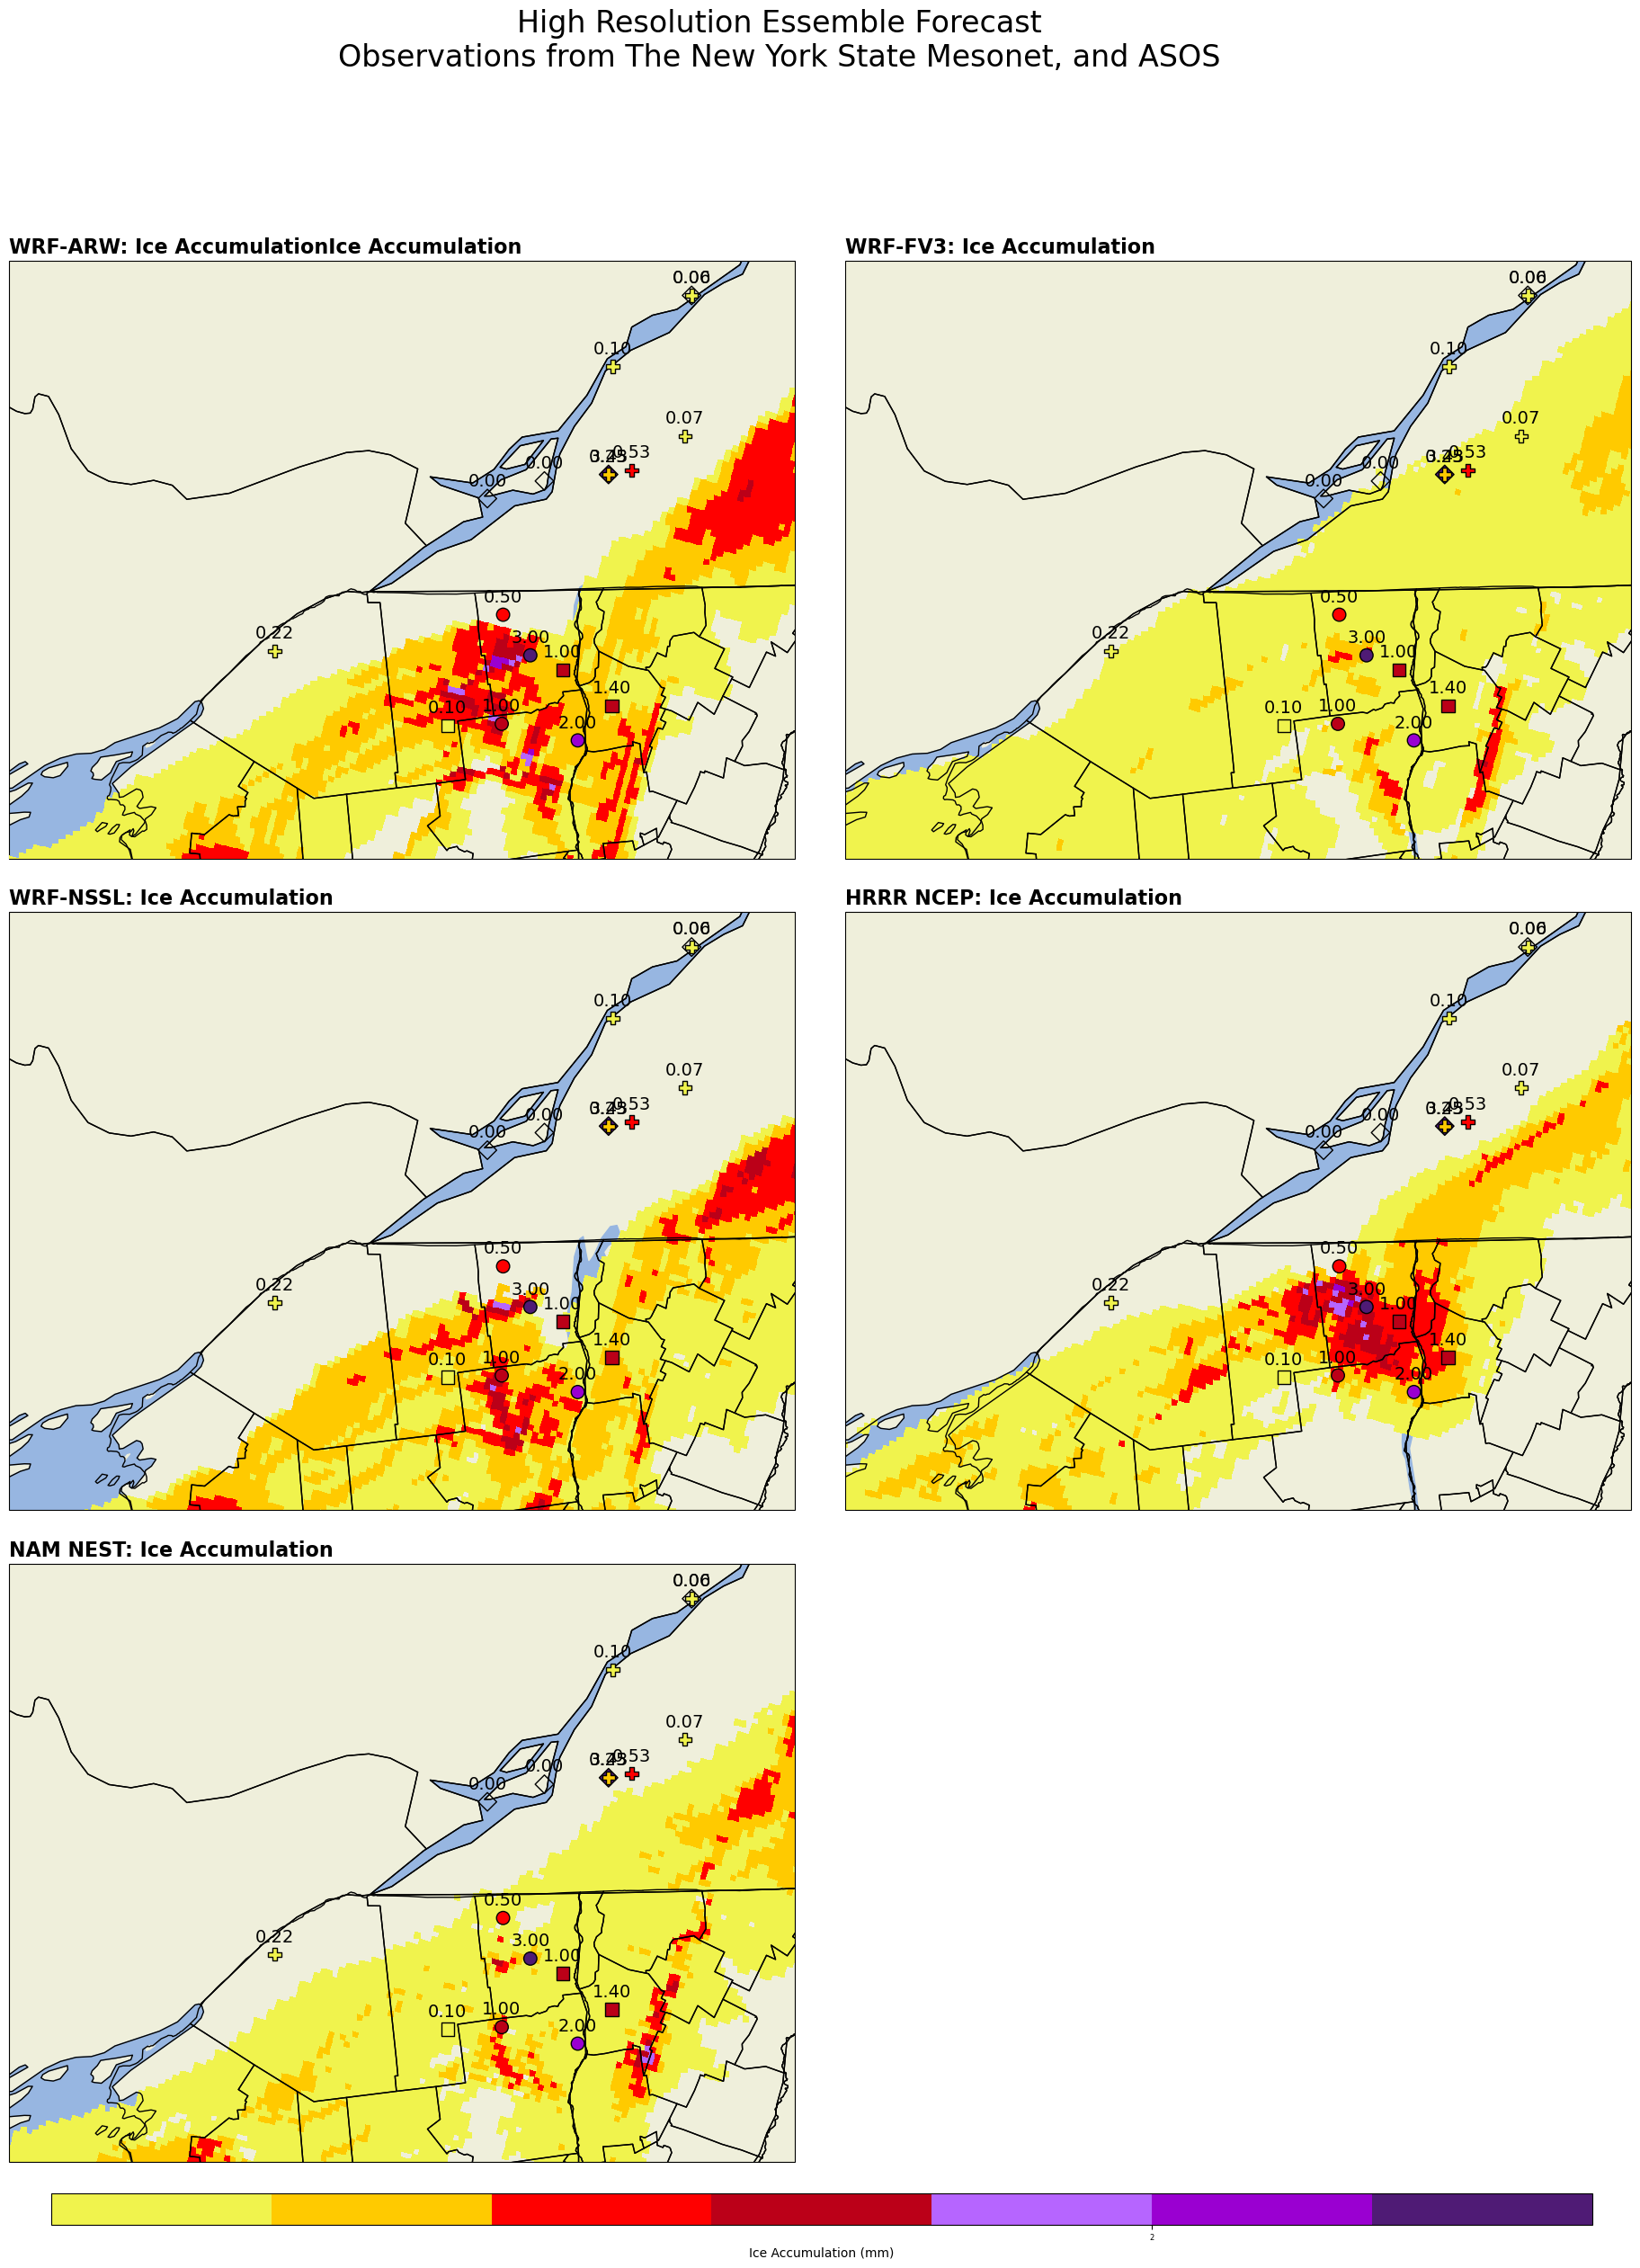

In [13]:
# Full Figure Title
tl0 = 'High Resolution Essemble Forecast'
tl1 = 'Observations from The New York State Mesonet, and ASOS'
#tl2 = f'Initilized: {valid_time_str} UTC, Forecast Hour: [{i}], Valid: {titlestrend} UTC'    
#title_line = (tl0+ '\n' + tl2 + '\n' + tl1)
title_line = (tl0+ '\n' + tl1)
 
# Subplot Figure Titles
variable = 'Ice Accumulation'
model1_t = 'WRF-ARW: ' + variable
model2_t = 'WRF-FV3: ' + variable
model3_t = 'WRF-NSSL: ' + variable
model4_t = 'HRRR NCEP: ' + variable
model5_t = 'NAM NEST: ' + variable

# Location (WINTRE-MIX)
latN_c = 46.5
latS_c = 43.75
lonW_c = -77.0
lonE_c = -72.0
cLat_c = (latN + latS)/2
cLon_c = (lonW + lonE )/2
    
# ASOS & NYSM Features
color ='black'
fontsize = 12
county_lw, county_scale = 1.0, '5m'
cbarna = 'coolwarm' #'jet'
    
#values = NYSM_temp.values
MAX = 2.5 # 20 max(values) 
MIN = 0 # -20 min(values)
norm = mpl.colors.Normalize(MIN, MAX)
    
# Figure Features
res = '50m'
proj = ccrs.LambertConformal(central_longitude=cLon_c, central_latitude=cLat_c)
msize = 110
cmap, norm, frzr_levs = cmatmos.frzr_cm() #NWS standard freezing rain colormap
    
# Surface Temperature Figure
fig = plt.figure(figsize=(36,28),dpi=100)
fig.suptitle(title_line, fontsize = 24) # Main Figure Title
plt.subplots_adjust(left = None, bottom = None, right = None, top = None, wspace = -.5, hspace = .09)

ax1 = fig.add_subplot(3,2,1, projection=proj)
ax1.set_title(model1_t + variable,fontsize=16,loc = 'left',fontweight = 'bold')
features(ax1)    
ARW = ax1.pcolormesh(LON, LAT, ARW_TOTAL, shading = 'auto', zorder = 3, cmap = cmap, norm = norm, transform = ccrs.PlateCarree())

ax2 = fig.add_subplot(3,2,2, projection=proj) # Setting up subplot & projection
ax2.set_title(model2_t, fontsize=16,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
features(ax2)
FV3 = ax2.pcolormesh(LON, LAT, FV3_TOTAL, shading = 'auto', zorder = 2, cmap = cmap, norm = norm, transform = ccrs.PlateCarree())

ax3 = fig.add_subplot(3,2,3, projection=proj) # Setting up subplot & projection
ax3.set_title(model3_t,fontsize=16,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
features(ax3)
NSSL = ax3.pcolormesh(LON, LAT, NSSL_TOTAL, shading = 'auto', zorder = 2, cmap = cmap, norm = norm, transform = ccrs.PlateCarree())

ax4 = fig.add_subplot(3,2,4, projection=proj) # Setting up subplot & projection
ax4.set_title(model4_t,fontsize=16,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
features(ax4)
NCEP = ax4.pcolormesh(LON, LAT, NCEP_TOTAL, shading = 'auto', zorder = 2, cmap = cmap, norm = norm, transform = ccrs.PlateCarree())

ax5 = fig.add_subplot(3,2,5, projection=proj) # Setting up subplot & projection
ax5.set_title(model5_t,fontsize=16,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
features(ax5)
NAM = ax5.pcolormesh(LON, LAT, NAM_TOTAL, shading = 'auto', zorder = 2, cmap = cmap, norm = norm, transform = ccrs.PlateCarree())

colorbar_axes = fig.add_axes([0.275, 0.1, .476, .0125])# Left Bottom Width Height
cbar = plt.colorbar(ARW, ticks = np.arange(MIN,MAX+1,2), orientation = 'horizontal', shrink = .35,cax = colorbar_axes)
cbar.ax.set_xlabel("Ice Accumulation (mm)",fontsize=10)
cbar.ax.tick_params(labelsize=6)

fig